In [1]:
from css_utility import *
from matplotlib.pyplot import figure
from scipy.stats import norm
import itertools

In [5]:
chr1_4mer_pre=pd.read_csv("../database/pretrain/test_telo_v1/eval_results_chr1_4mer_v1_01.txt", header=None)

<AxesSubplot:>

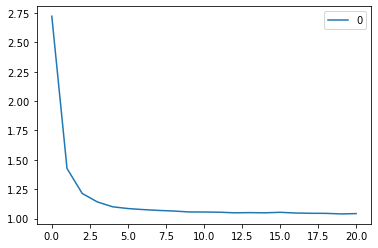

In [7]:
chr1_4mer_pre.plot()

In [2]:
path

'../database/bed/unzipped/'

[Specification](#Specification)

In [3]:
whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'

In [4]:
g_lst_chr=whGene2GLChr(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed')

In [5]:
len(g_lst_chr)

24

In [6]:
sample1_path=all_files[0]
print(sample1_path)

../database/bed/unzipped/E001_15_coreMarks_stateno.bed


In [7]:
df=bed2df_expanded(sample1_path)

In [8]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


# Specification

In [9]:
df_lst_chr=df2chr_df(df)

In [10]:
# make a long string of the css (not using unit, but the real length)

def df2longcss(df):
    df_lst_chr=df2chr_df(df)
    # remove the microchondria DNA from df_lst_chr
    if df_lst_chr[-3]["chromosome"].iloc[0]=="chrM":
        del df_lst_chr[-3]
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    else:   
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    
    all_css=[]
    for i in range(len(df_lst_chr)):
        df_chr=df_lst_chr[i]
        css_chr=''
        for j in range(len(df_chr)):
            css_chr+=df_chr["length"].iloc[j]*df_chr["state_seq"].iloc[j]
        all_css.append(css_chr)  
    return all_css    # list of css per chromosome in a cell

In [11]:
all_css=df2longcss(df)

In [12]:
len(all_css[0])

249250600

In [13]:
a,b=0,6

In [14]:
all_css[0][a:b]

'OOOOOO'

In [15]:
def compGene2css(whole_gene_file,df):
    g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_gene_lst_all=[]
    for i in range(total_chr):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    return css_gene_lst_all


In [16]:
css_gene_lst_all=compGene2css(whole_gene_file,df)

In [17]:
len(css_gene_lst_all)

24

In [18]:
a="AAJJJJ"
"A" in a

True

In [19]:
css_gene_lst_all[0][3]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

#### How many gene contains quiescent state?

In [20]:
# sum overall : for cell-wise
q_cnt=0
not_q_cnt=0
for i in range(len(css_gene_lst_all)):
    css_gene_lst=css_gene_lst_all[i]
    for j in range(len(css_gene_lst)):
        css_gene=css_gene_lst[j]
        if "O" in css_gene:
            q_cnt+=1
        else:
            not_q_cnt+=1
print("No. of gene contains quiescent state: ", q_cnt)
print("No. of gene does not quiescent state: ", not_q_cnt)

No. of gene contains quiescent state:  28832
No. of gene does not quiescent state:  23428


In [21]:
# make it a list of list : for chromosome-wise
q_cnt_lst=[]
not_q_cnt_lst=[]
for i in range(len(css_gene_lst_all)):
    css_gene_lst=css_gene_lst_all[i]
    
    q_cnt=0
    not_q_cnt=0
    for j in range(len(css_gene_lst)):
        css_gene=css_gene_lst[j]
        if "O" in css_gene:
            q_cnt+=1
        else:
            not_q_cnt+=1
    q_cnt_lst.append(q_cnt)
    not_q_cnt_lst.append(not_q_cnt)
    
print("No. of gene contains quiescent state: ", q_cnt_lst[0])
print("No. of gene does not quiescent state: ", not_q_cnt_lst[0])

No. of gene contains quiescent state:  2693
No. of gene does not quiescent state:  2562


In [22]:
np.sum(q_cnt_lst)

28832

#### And is it differ depending upon cell types?

In [23]:
# for cell-wise count : how many 15th-including genes are there per cell

def QnonQforCell(all_files=all_files,whole_gene_file=whole_gene_file):
    total_cells=len(all_files)
    
    q_cnt_lst=[]
    not_q_cnt_lst=[]
    for i in range(total_cells):
        cell_path=all_files[i]
        df=bed2df_expanded(cell_path)
        css_gene_lst_all=compGene2css(whole_gene_file,df)
        
        q_cnt=0
        not_q_cnt=0
        for j in range(len(css_gene_lst_all)):
            css_gene_lst=css_gene_lst_all[j]
            for k in range(len(css_gene_lst)):
                css_gene=css_gene_lst[k]
                if "O" in css_gene:
                    q_cnt+=1
                else:
                    not_q_cnt+=1
        q_cnt_lst.append(q_cnt)
        not_q_cnt_lst.append(not_q_cnt)
    return q_cnt_lst, not_q_cnt_lst

#### And is it differ depending upon chromosome?

In [24]:
q_cnt_lst, not_q_cnt_lst=QnonQforCell(all_files,whole_gene_file)

In [25]:
np.mean(q_cnt_lst)

25451.889763779527

In [26]:
np.mean(not_q_cnt_lst)

26808.110236220473

In [27]:
# print("No. of cell types: ",len(all_files))

def QnonQforChr(all_files=all_files,whole_gene_file=whole_gene_file):
#     import itertools
    total_cells=len(all_files)
    
    q_cnt_lst_all=[]
    not_q_cnt_lst_all=[]
    for i in range(total_cells):
        cell_path=all_files[i]
        df=bed2df_expanded(cell_path)
        css_gene_lst_all=compGene2css(whole_gene_file,df)
        
        q_cnt_lst=[]
        not_q_cnt_lst=[]
        for j in range(len(css_gene_lst_all)):
            css_gene_lst=css_gene_lst_all[j]
            
            q_cnt=0
            not_q_cnt=0
            for k in range(len(css_gene_lst)):
                css_gene=css_gene_lst[k]
                if "O" in css_gene:
                    q_cnt+=1
                else:
                    not_q_cnt+=1
                    
            q_cnt_lst.append(q_cnt)
            not_q_cnt_lst.append(not_q_cnt)        
        q_cnt_lst_all.append(q_cnt_lst)
        not_q_cnt_lst_all.append(not_q_cnt_lst)

#     flatten the list of list and make it into list
    q_cnt_lst_all=list(itertools.chain.from_iterable(q_cnt_lst_all))
    not_q_cnt_lst_all=list(itertools.chain.from_iterable(not_q_cnt_lst))
        
    return q_cnt_lst_all, not_q_cnt_lst_all

In [28]:
q_cnt_lst_all, not_q_cnt_lst_all=QnonQforChr(all_files,whole_gene_file)

TypeError: 'int' object is not iterable

In [ ]:
# q_cnt_lst_all=list(itertools.chain.from_iterable(q_cnt_lst_all))
not_q_cnt_lst_all=list(itertools.chain.from_iterable(not_q_cnt_lst_all))

In [ ]:
len(not_q_cnt_lst_all)

In [ ]:
def QnonQforCellHistT1(q_cnt_lst, not_q_cnt_lst, bin_size=15):
    """Run this after executing QnonQforCell"""
    data_w=q_cnt_lst
    data_wo=not_q_cnt_lst

    mu_w, std_w=norm.fit(data_w)
    mu_wo, std_wo=norm.fit(data_wo)

    plt.hist(data_w, bins=bin_size, alpha=0.3, color="k")
    plt.hist(data_wo, bins=bin_size, alpha=0.5, color="r")

#     xmin_w, xmax_w=plt.xlim()
#     xmin_wo, xmax_wo=plt.xlim()

#     x_w = np.linspace(xmin_w, xmax_w, 100)
#     p_w = norm.pdf(x_w, mu_w, std)
#     x_wo = np.linspace(xmin_wo, xmax_wo, 100)
#     p_wo = norm.pdf(x_wo, mu_wo, std)

#     plt.plot(x_w, p_w, "r", linewidth=2)
#     plt.plot(x_wo, p_wo, "k", linewidth=2)

    title='Number of Genic region with/without Quiescent state'
    plt.title(title)
#     plt.legend("with Quiescent state","without Quiescent state")
    plt.xlabel("No. of Genes")
    plt.ylabel("Counts")
    plt.show()

In [ ]:
QnonQforCellHistT1(q_cnt_lst, not_q_cnt_lst,10)  # per cell, how many genes with/out o per cell

In [ ]:
QnonQforCellHistT1(q_cnt_lst_all, not_q_cnt_lst_all,20)  # total gene in all samples (more detailed)

In [ ]:
def QnonQforCellHistT2(q_cnt_lst, not_q_cnt_lst,bin_size):
    """Run this after executing QnonQforCell"""
    data_w=q_cnt_lst
    data_wo=not_q_cnt_lst

    mu_w, std_w=norm.fit(data_w)
    mu_wo, std_wo=norm.fit(data_wo)

    fig=plt.figure(figsize=(8,4))
    ax=fig.add_subplot(1,1,1)
    ax.hist([data_w,data_wo], bins=bin_size, alpha=0.5, color=["teal","orange"], label=["with Quiescent state","without Quiescent state"])

#     xmin_w, xmax_w=plt.xlim()
#     xmin_wo, xmax_wo=plt.xlim()

#     x_w = np.linspace(xmin_w, xmax_w, 100)
#     p_w = norm.pdf(x_w, mu_w, std)
#     x_wo = np.linspace(xmin_wo, xmax_wo, 100)
#     p_wo = norm.pdf(x_wo, mu_wo, std)

    ax.legend(loc="upper left")

#     plt.plot(x_w, p_w, "teal", linewidth=2)
#     plt.plot(x_wo, p_wo, "orange", linewidth=2)

    title='Number of Genic region with/without Quiescent state'
    plt.title(title)
    plt.legend()
    plt.xlabel("No. of Genes")
    plt.ylabel("Counts")
    plt.show()

In [ ]:
QnonQforCellHistT2(q_cnt_lst, not_q_cnt_lst,10)

In [ ]:
QnonQforCellHistT2(q_cnt_lst_all, not_q_cnt_lst_all,20)

#### No. of 15 state in the genic region?

In [ ]:
len(css_gene_lst_all) # list of list, per chromosome

In [ ]:
css_gene_lst_all[0][0].count("O") # built-in function count

In [ ]:
# generate thee lists: 15th state-including gene count, gene length, proportion of 15th state per gene
def cntQinGene(css_gene_lst_all):
    """run this after executing compGene2css(whole_gene_file,df)
       [Input]
       css_gene_lst_all : list of css list of each chromosome
       [Output]
       cnt_o_lst : list of Quiescent state counts list per chromosome
       gene_len_lst : list of gene length (in terms of chromatin state Anno.200bps) list per chromosome
       pro_o_lst : list of proportion of Quiescent state per gene list per chromosome
    """
    cnt_o_lst=[]
    gene_len_lst=[]
    pro_o_lst=[]
    for i in range(len(css_gene_lst_all)):
        css_gene_lst=css_gene_lst_all[i]
        
        cnt_o_chr=[]
        gene_len_chr=[]
        pro_o_chr=[]
        for j in range(len(css_gene_lst)):
            css_gene=css_gene_lst[j]
            cnt_o=css_gene.count("O")
            gene_len=len(css_gene)
            pro_o=cnt_o/gene_len
            
            cnt_o_chr.append(cnt_o)
            gene_len_chr.append(gene_len)
            pro_o_chr.append(pro_o)
            
        cnt_o_lst.append(cnt_o_chr)
        gene_len_lst.append(gene_len_chr)
        pro_o_lst.append(pro_o_chr)
        
    return cnt_o_lst, gene_len_lst, pro_o_lst

In [ ]:
cnt_o_lst, gene_len_lst, pro_o_lst=cntQinGene(css_gene_lst_all)

In [ ]:
pro_o_lst[0][500]

In [ ]:
cnt_o_lst[0][500]

In [ ]:
gene_len_lst[0][500]

In [ ]:
#flatten
cnt_o_lst=list(itertools.chain.from_iterable(cnt_o_lst))
gene_len_lst=list(itertools.chain.from_iterable(gene_len_lst))
pro_o_lst=list(itertools.chain.from_iterable(pro_o_lst))

In [ ]:
fig=plt.figure(figsize=(4,6))
plt.boxplot([cnt_o_lst, gene_len_lst])
plt.show()

In [ ]:
fig=plt.figure(figsize=(4,3))
plt.boxplot(pro_o_lst)
plt.show()

In [ ]:
plt.hist(pro_o_lst, bins=100, density=True, log=True, alpha=0.5, color="r" )
plt.title("Proportion of 15th state in genes")
plt.show()


In [ ]:
df.tail()

In [ ]:
# divide into two step

# step 1. just divide into Q-included, Q-excluded
# pre-requisite: run function "compGene2css(whole_gene_file,df)"  to create 'css_gene_lst_all'
# input : css_gene_lst_all (whole gene in a cell per chromosome, represented as css anno.)
# output : q_gene_lst, non_q_gene_lst (flatten)

def QnonQgene(css_gene_lst_all):
    """
    Prerequisite: run the function "compGene2css" to get 'css_gene_lst_all'
    input: css_gene_lst_all
    output: q_gene, non_q_gene, flatten lists of the gene containing 15th/ without 15th
    """
    css_gene_lst_all_f=list(itertools.chain.from_iterable(css_gene_lst_all)) # flatten the list of list
    total_gene=len(css_gene_lst_all_f) # in a specific cell (here, df)
    
    q_gene_lst=[]      # prepare the list of q_anno. included gene
    non_q_gene_lst=[]  # prerpare the list of the whole non_q_anno. gene
    
    for i in range(total_gene):
        if "O" in css_gene_lst_all_f[i]:
            q_gene_lst.append(css_gene_lst_all_f[i])
        else:
            non_q_gene_lst.append(css_gene_lst_all_f[i])
    return q_gene_lst, non_q_gene_lst

In [ ]:
q_gene_lst, non_q_gene_lst=QnonQgene(css_gene_lst_all)

In [ ]:
len(non_q_gene_lst)

In [ ]:
# step 2. 
# How is the composition of the gene (css) that are NOT annotated with 15th state?

def QNonQcomp_count(q_gene_lst, non_q_gene_lst):
    """
    [Input]
    q_gene_lst, non_q_gene_lst : acquired by running 'QnonQgene(css_gene_lst_all)'
    
    [Output]
    2. q_dict_lst: list of dictionary of which key=state, value=count, for a gene containing 15th state
    3. q_count_lst: list of counts, the no. of composition of the gene containing 15th state
    5. non_q_dict_lst: counterpart of 2. without 15th
    6. non_q_count_lst: counterpart of 3. without 15th
    """   
    q_dict_lst=[] # to store the dict list (list of dictionary)
    q_count_lst=[]  # list of a number (list of numbers)
    
    non_q_dict_lst=[]  # to store the dict list (list of dictionary)
    non_q_count_lst=[]  # list of a number (list of numbers)
   
    for gene_q in q_gene_lst:
        q_uniq_set=set(gene_q)
        q_dict=dict.fromkeys(gene_q,0) # prerpare the initial dictionary (state-count)
        for key in q_dict.keys():
            q_dict[key]=gene_q.count(key)

        q_dict_lst.append(q_dict)  # to return
        q_count_lst.append(len(q_dict))  # to return
                
        #### do the same thing for q -included gene

    for non_gene_q in non_q_gene_lst:
        non_q_uniq_set=set(non_gene_q)
        non_q_dict=dict.fromkeys(non_gene_q,0) # prerpare the initial dictionary (state-count)

        for key in non_q_dict.keys():
            non_q_dict[key]=non_gene_q.count(key)

        non_q_dict_lst.append(non_q_dict)
        non_q_count_lst.append(len(non_q_dict))
    
    assert len(q_dict_lst)==len(q_count_lst)
    assert len(non_q_dict_lst)==len(non_q_count_lst)
    
    return q_dict_lst, q_count_lst, non_q_dict_lst, non_q_count_lst


In [ ]:
q_dict_lst, q_count_lst, non_q_dict_lst, non_q_count_lst=QNonQcomp_count(q_gene_lst, non_q_gene_lst)

In [ ]:
len(non_q_dict_lst)

In [ ]:
len(non_q_count_lst)

In [ ]:
plt.hist(q_count_lst, bins=10, alpha=0.9, color="teal", edgecolor="w")
plt.title("No. of composition in genic region including Quiescent state")
plt.show()

In [ ]:
plt.hist(non_q_count_lst, bins=10, alpha=0.9, color="orange", edgecolor="w")
plt.title("No. of composition in genic region without Quiescent state")
plt.show()

In [ ]:
def QnonQcomp_state(q_gene_lst, non_q_gene_lst):
    
    

In [47]:
# How is the composition of the gene (css) that are NOT annotated with 15th state?

def QNonQcompChr(whole_gene_file, df):
    """
    [Input]
    1. whole_gene_file: gene position table hg19
    2. df: dataframe of a specific cell acquired by the func 'bed2df_expanded' 
    
    [Output]
    1. non_q_lst: list of the whole gene (as a css annotated) without 15th state
    2. non_q_dict_lst: list of dictionary of which key=state, value=count, for a gene without 15th state
    3. non_q_count_lst: list of counts, the no. of composition of the gene without 15th state
    4. q_lst: counterpart of 1. non_q_lst
    5. q_dict_lst: counterpart of 2. non_q_dict_lst
    6. q_count_lst: counterpart of 3. non_q_count_lst
    """
    
    css_gene_lst_all=compGene2css(whole_gene_file,df)  # list of list of gene (represented as css anno.) in a chromosome    
    css_gene_lst_all_f=list(itertools.chain.from_iterable(css_gene_lst_all)) # flatten the list of list
    total_gene=len(css_gene_lst_all_f) # in a specific cell (here, df)
    
    non_q_lst=[]  # prerpare the list of the whole non_q_anno. gene
    non_q_dict_lst=[]  # to store the dict list (list of dictionary)
    non_q_count_lst=[]  # list of a number (list of numbers)
    
    q_lst=[]  # prepare the list of q_anno. included gene
    q_dict_lst=[] # to store the dict list (list of dictionary)
    q_count_lst=[]  # list of a number (list of numbers)
    
    for i in range(total_gene):
        if "O" not in css_gene_lst_all_f[i]:
            non_q_lst.append(css_gene_lst_all_f[i])   # list of non Q           
#             non_q_dict_lst=[]  # to store the dict list (list of dictionary)
#             non_q_count_lst=[]  # list of a number (list of numbers)
            for gene_non_q in css_gene_lst_all_f[i]:
                non_q_uniq_set=set(gene_non_q)
                non_q_dict=dict.fromkeys(gene_non_q,0) # prerpare the initial dictionary (state-count)
                
                for key in non_q_dict.keys():
                    non_q_dict[key]=gene_non_q.count(key)
                
                non_q_dict_lst.append(non_q_dict)  # to return
                non_q_count_lst.append(len(non_q_dict))  # to return
                
        #### do the same thing for q -included gene
        else:
            q_lst.append(css_gene_lst_all_f[i]) # list of Q-included 
#             q_dict_lst=[] # to store the dict list (list of dictionary)
#             q_count_lst=[]  # list of a number (list of numbers)
            for gene_q in css_gene_lst_all_f[i]:
                q_uniq_set=set(gene_q)
                q_dict=dict.fromkeys(gene_q,0) # prerpare the initial dictionary (state-count)
                
                for key in q_dict.keys():
                    q_dict[key]=gene_q.count(key)
                
                q_dict_lst.append(q_dict)
                q_count_lst.append(len(q_dict))
    
    return non_q_lst, non_q_dict_lst, non_q_count_lst, q_lst, q_dict_lst, q_count_lst
    
    
  